In [ ]:
import copy
import os
import time
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

torch.manual_seed(1)

### Settings

In [ ]:
# download en_core_web_sm with "python -m spacy download en_core_web_sm"
nlp = spacy.load("en_core_web_sm")
data_path = "data/"

device = "cuda"

# k for the k most occuring words
k = 1000
# key to decide if we want to use cleaned words or not
wkey = "clean_words" # "words" or "clean_words"

# single data point settings (Single Line)
SL_EMBEDDING_DIM = 128
SL_HIDDEN_DIM = 256
SL_EPOCHS = 3
SL_LR = 0.005
SL_DROPOUT = 0.0

# batch data point settings (Batch Line)
BL_EMBEDDING_DIM = 768
BL_HIDDEN_DIM = 768
BL_EPOCHS = 10
BL_LR = 0.0004
BL_LAYER = 2 # layer of the LSTM, GRU
BL_DROPOUT = 0.3
BATCH_SIZE = 64

### Data loading and processing

In [ ]:
def load_data(split, amount=-1):
    data = defaultdict(dict)
    indices_to_remove = []
    with open(os.path.join(data_path, split + "_text.txt"), "r", encoding="utf-8") as f:
        txt_lines = f.read().strip().splitlines()
        txt_lines = txt_lines[:amount] if amount != -1 else txt_lines
        for i, line in enumerate(tqdm(txt_lines, desc=f"Loading {split} data")):
            data[i]["text"] = line.strip()
            clean_words = []
            words = []
            for token in nlp(line.strip()):
                words.append(token.text)
                if token.is_alpha and not token.is_stop:
                    clean_words.append(token.lemma_.lower())
                elif token.text in ["!", "?", "#", "@"]:
                    clean_words.append(token.text)
            data[i]["clean_words"] = clean_words
            data[i]["words"] = words

            if len(clean_words) == 0:
                indices_to_remove.append(i)

    with open(os.path.join(data_path, split + "_labels.txt"), "r", encoding="utf-8") as f:
        txt_lines = f.read().strip().splitlines()
        txt_lines = txt_lines[:amount] if amount != -1 else txt_lines
        for i, line in enumerate(txt_lines):
            data[i]["label"] = int(line.strip())

    for indice in indices_to_remove:
        del data[indice]

    print(f"Removed {len(indices_to_remove)} samples with no clean words")
    return data

In [ ]:
with open(os.path.join(data_path, "mapping.txt")) as f:
    mapping = {int(line.split()[0]): line.split()[1] for line in f}

num_classes = len(mapping)

train_data = load_data("train")
val_data = load_data("val")
# concat train and val data
train_data.update(val_data)
test_data = load_data("test")

Loading train data:   0%|          | 0/3257 [00:00<?, ?it/s]

Removed 2 samples with no clean words


Loading val data:   0%|          | 0/374 [00:00<?, ?it/s]

Removed 1 samples with no clean words


Loading test data:   0%|          | 0/1421 [00:00<?, ?it/s]

Removed 2 samples with no clean words


In [ ]:
def get_word_freq(data, key="words"):
    # go through all words and count them
    c = Counter()
    for data in data.values():
        # key is either "words" or "clean_words"
        c.update(data[key])
    return c

def get_k_most_common_words(k, word_freq):
    # get the k most common words
    return [word for word, _ in word_freq.most_common(k)]

def build_word_to_ix(k_most_words):
    # build a dictionary that maps words to indices and add an index for unknown words
    word_to_ix = {word: i for i, word in enumerate(k_most_words)}
    word_to_ix["<UNK>"] = len(word_to_ix)
    word_to_ix["<PAD>"] = len(word_to_ix)
    return word_to_ix

In [ ]:
class word_tokenizer:
    def __init__(self, word_to_ix):
        self.word_to_ix = word_to_ix
        self.ix_to_word = {v: k for k, v in word_to_ix.items()}
        self.unknown_id = word_to_ix["<UNK>"]
        self.pad_id = word_to_ix["<PAD>"]

    def __len__(self):
        return len(self.word_to_ix)

    def __call__(self, words):
        return [self.word_to_ix.get(word, self.unknown_id) for word in words]

    def pad(self, words, max_len):
        return words + [self.pad_id] * (max_len - len(words))

    def unpad(self, words):
        return words[:words.index(self.pad_id)] if self.pad_id in words else words

    def encode(self, ids):
        return [self.ix_to_word[id] for id in ids]

    def batch_encode(self, batch_ids):
        return [self.encode(ids) for ids in batch_ids]

In [ ]:
word_freq = get_word_freq(train_data, wkey)
k_most_words = get_k_most_common_words(k, word_freq)
word_to_ix = build_word_to_ix(k_most_words)
tokenizer = word_tokenizer(word_to_ix)

In [ ]:
print(f"Number of words: {len(word_freq)}")
print(f"Number of words in tokenizer: {len(tokenizer)}")
print(f"5 most common words: {word_freq.most_common(5)}")
print(f"5 least common words: {word_freq.most_common()[-5:]}")

Number of words: 6576
Number of words in tokenizer: 1002
5 most common words: [('#', 3364), ('!', 817), ('?', 437), ('like', 238), ('amp', 139)]
5 least common words: [('homefronttherevolution', 1), ('gameplay', 1), ('wasteofmoney', 1), ('grad', 1), ('shallowness', 1)]


In [ ]:
# get a sample data point and convert it to a tensor
sample_data_point = train_data[0]
print(f"Sample data point raw text: {sample_data_point['text']}")
print(f"Sample data point words: {sample_data_point['words']}")
print(f"Sample data point clean words: {sample_data_point['clean_words']}")
tokenized = tokenizer(sample_data_point[wkey])
print(f"Sample data point tokenized: {tokenized}")
print(f"Encoded text: {tokenizer.encode(tokenized)}")
sample_label = sample_data_point["label"]
print(f"Sample data point label: {mapping[sample_label]} ({sample_label})")

Sample data point raw text: @user @user Oh, hidden revenge and anger...I rememberthe time,she rebutted you.
Sample data point words: ['@user', '@user', 'Oh', ',', 'hidden', 'revenge', 'and', 'anger', '...', 'I', 'rememberthe', 'time', ',', 'she', 'rebutted', 'you', '.']
Sample data point clean words: ['oh', 'hide', 'revenge', 'anger', 'rememberthe', 'time', 'rebut']
Sample data point tokenized: [73, 858, 124, 48, 1000, 12, 1000]
Encoded text: ['oh', 'hide', 'revenge', 'anger', '<UNK>', 'time', '<UNK>']
Sample data point label: anger (0)


In [ ]:
def calculate_stats(data):
    num_tokens = sum(len(tokenizer(data_point[wkey])) for data_point in data.values())
    class_distribution = Counter(mapping.get(data_point["label"]) for data_point in data.values())
    return num_tokens, class_distribution

Number of tokens in train: 29115
Class distribution in train: Counter({'anger': 1399, 'sadness': 856, 'joy': 714, 'optimism': 286})
Number of tokens in test: 12686


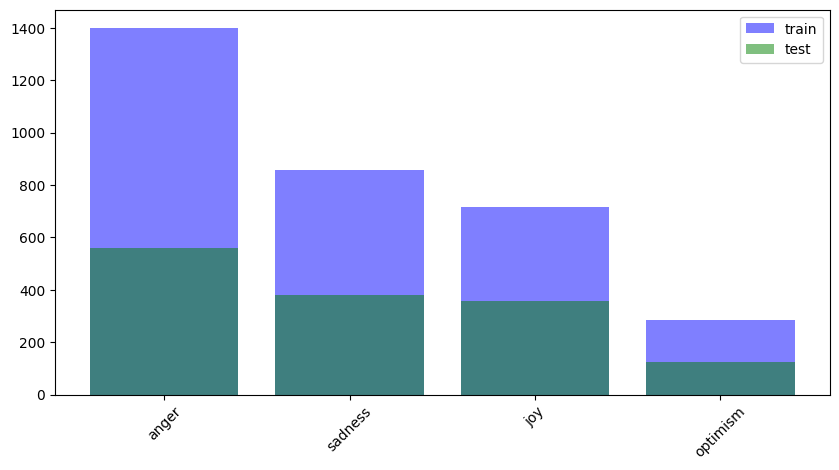

In [ ]:
num_tokens_train, class_distribution_train = calculate_stats(train_data)
# num_tokens_val, class_distribution_val = calculate_stats(val_data)
num_tokens_test, class_distribution_test = calculate_stats(test_data)

print(f"Number of tokens in train: {num_tokens_train}")
print(f"Class distribution in train: {class_distribution_train}")
# print(f"Number of tokens in val: {num_tokens_val}")
print(f"Number of tokens in test: {num_tokens_test}")

plt.figure(figsize=(10, 5))
plt.bar(class_distribution_train.keys(), class_distribution_train.values(), color="blue", alpha=0.5, label="train")
# plt.bar(class_distribution_val.keys(), class_distribution_val.values(), color="red", alpha=0.5, label="val")
plt.bar(class_distribution_test.keys(), class_distribution_test.values(), color="green", alpha=0.5, label="test")
plt.xticks(rotation=45)
plt.legend()

### Train with Single Data Points (Without Batch)

In [ ]:
class LSTMSimple(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes):
        super(LSTMSimple, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence).unsqueeze(0)
        lstm_out, (hidden, cell) = self.lstm(embeds)
        dense_output = self.fc(hidden[-1])
        return dense_output

class GRUSimple(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes):
        super(GRUSimple, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence).unsqueeze(0)
        gru_out, hidden = self.gru(embeds)
        dense_output = self.fc(hidden[-1])
        return dense_output

In [ ]:
def train_single_line(epochs, model, train_data, loss_fn, optimizer, tokenizer):
    model = model.train()
    train_stats = defaultdict(list)

    start_time = time.time()

    for epoch in tqdm(range(epochs), desc="Epochs"):
        correct = 0
        total = 0
        sum_loss = 0

        for i, data in enumerate(train_data.values()):
            model.zero_grad()

            sentence_in = torch.tensor(tokenizer(data[wkey]), dtype=torch.long)
            targets = torch.tensor([data["label"]], dtype=torch.long)

            tag_scores = model(sentence_in)

            loss = loss_fn(tag_scores, targets)
            loss.backward()
            optimizer.step()

            train_stats["loss"].append(loss.item())
            sum_loss += loss.item()

            _, predicted = torch.max(tag_scores, 1)
            total += 1
            correct += (predicted == targets).sum().item()

        train_stats["accuracy"].append((correct / total) * 100)
        train_stats["avg_loss"].append(sum_loss / total)

    print(f"Training took {time.time() - start_time:.2f} seconds")

    plt.plot(train_stats["accuracy"])
    plt.title("Training accuracy")
    plt.show()

    plt.plot(train_stats["avg_loss"])
    plt.title("Training loss")
    plt.show()

    return model

def test_single_line(model, test_data, tokenizer):
    model = model.eval()
    test_results = defaultdict(list)

    for i, data in tqdm(test_data.items(), desc="Testing"):
        sentence_in = torch.tensor(tokenizer(data[wkey]), dtype=torch.long)
        test_results["text"].append(data["text"])
        test_results["words"].append(data["words"])
        test_results["clean_words"].append(data["clean_words"])

        with torch.no_grad():
            out = model(sentence_in)
        probs = F.softmax(out, dim=1).detach().numpy().flatten()

        test_results["probs"].append(probs)
        pred = torch.argmax(out).item()
        test_results["pred"].append(pred)
        test_results["pred_label"].append(mapping[pred])
        test_results["true"].append(data["label"])
        test_results["true_label"].append(mapping[data["label"]])

    return pd.DataFrame(test_results)

In [ ]:
def calculate_test_accuracy(test_results):
    return ((test_results["pred"] == test_results["true"]).sum() / len(test_results)) * 100

def calculate_test_accuracy_per_class(test_results):
    accuracy_per_class = defaultdict(int)
    class_count = defaultdict(int)

    for i, row in test_results.iterrows():
        class_count[row["true_label"]] += 1
        if row["pred"] == row["true"]:
            accuracy_per_class[row["true_label"]] += 1

    for label, count in class_count.items():
        accuracy_per_class[label] /= count
        accuracy_per_class[label] *= 100

    return accuracy_per_class

def clean_probs(probs):
    out_str = ", ".join([f"{mapping[i]} ({prob*100:.0f}%)" for i, prob in enumerate(probs)])
    return out_str

def print_sample_results(test_results, n=5):
    for i, row in test_results.sample(n).iterrows():
        print(f"Text: {row['text']}")
        print(f"Words: {row['words']}")
        print(f"Clean words: {row['clean_words']}")
        print(f"True: {row['true_label']}, Pred: {row['pred_label']}")
        print(f"Probs: {clean_probs(row['probs'])}")
        print()

def print_test_results(results):
    print(f"Test accuracy: {calculate_test_accuracy(results):.2f}%")
    print("-"*100)
    print("Test accuracy per class:")
    accuracy_per_class = calculate_test_accuracy_per_class(results)
    for label, acc in accuracy_per_class.items():
        print(f"{label}: {acc:.2f}%")
    print("-"*100)
    print_sample_results(results, n=3)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training took 62.05 seconds


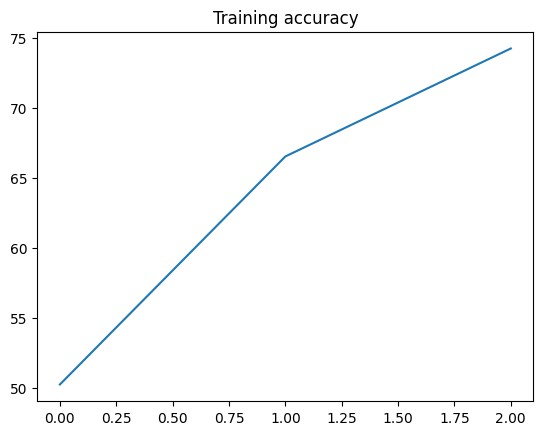

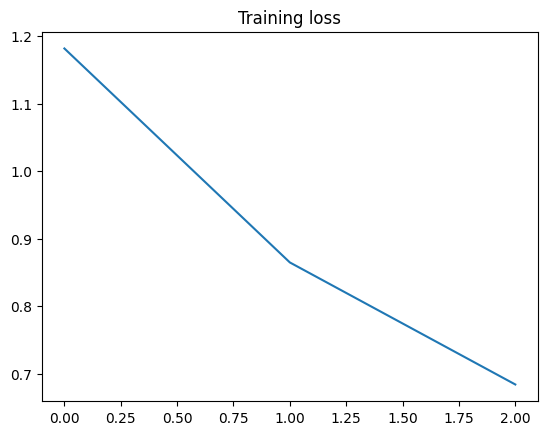

Testing:   0%|          | 0/1419 [00:00<?, ?it/s]

Test accuracy: 59.48%
----------------------------------------------------------------------------------------------------
Test accuracy per class:
sadness: 60.37%
anger: 77.60%
joy: 42.86%
optimism: 22.76%
----------------------------------------------------------------------------------------------------
Text: @user Truly dreadful
Words: ['@user', 'Truly', 'dreadful']
Clean words: ['truly', 'dreadful']
True: sadness, Pred: sadness
Probs: anger (5%), joy (0%), optimism (7%), sadness (88%)

Text: I'm fuming I wanted Hamez
Words: ['I', "'m", 'fuming', 'I', 'wanted', 'Hamez']
Clean words: ['fume', 'want', 'hamez']
True: anger, Pred: anger
Probs: anger (97%), joy (0%), optimism (1%), sadness (1%)

Text: #moist people aren't #offended by a little typo.
Words: ['#', 'moist', 'people', 'are', "n't", '#', 'offended', 'by', 'a', 'little', 'typo', '.']
Clean words: ['#', 'moist', 'people', '#', 'offend', 'little', 'typo']
True: optimism, Pred: anger
Probs: anger (64%), joy (1%), optimism (9%), 

In [ ]:
lstm_single = LSTMSimple(SL_EMBEDDING_DIM, SL_HIDDEN_DIM, len(tokenizer), num_classes)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_single.parameters(), lr=SL_LR)

lstm_single = train_single_line(SL_EPOCHS, lstm_single, train_data, loss_function, optimizer, tokenizer)
lstm_single_test_results = test_single_line(lstm_single, test_data, tokenizer)

print_test_results(lstm_single_test_results)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training took 78.02 seconds


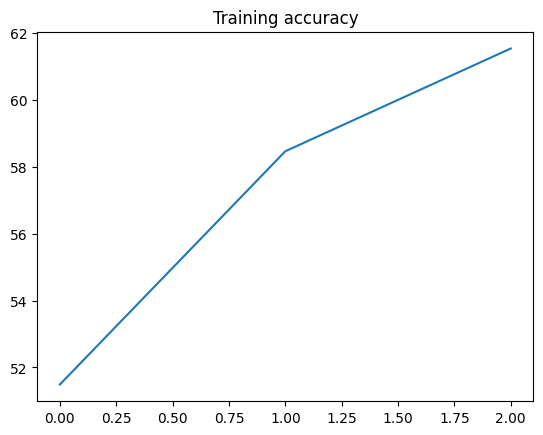

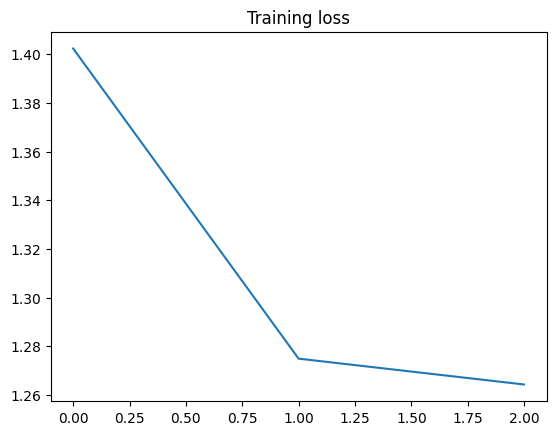

Testing:   0%|          | 0/1419 [00:00<?, ?it/s]

Test accuracy: 54.47%
----------------------------------------------------------------------------------------------------
Test accuracy per class:
anger: 78.85%
sadness: 46.72%
joy: 36.13%
optimism: 21.14%
----------------------------------------------------------------------------------------------------
Text: @user Fuck sake i'm fuming. on the upside at least I can keep loving the bloke and that he didn't sign for Chelsea or Liverpool..
Words: ['@user', 'Fuck', 'sake', 'i', "'m", 'fuming', '.', 'on', 'the', 'upside', 'at', 'least', 'I', 'can', 'keep', 'loving', 'the', 'bloke', 'and', 'that', 'he', 'did', "n't", 'sign', 'for', 'Chelsea', 'or', 'Liverpool', '..']
Clean words: ['fuck', 'sake', 'fume', 'upside', 'love', 'bloke', 'sign', 'chelsea', 'liverpool']
True: anger, Pred: anger
Probs: anger (95%), joy (0%), optimism (2%), sadness (3%)

Text: Would be ever so grateful if you could record Garden of Forgiveness gentleman @user @user #amazing
Words: ['Would', 'be', 'ever', 'so', 'gra

In [ ]:
gru_single = GRUSimple(SL_EMBEDDING_DIM, SL_HIDDEN_DIM, len(tokenizer), num_classes)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_single.parameters(), lr=SL_LR)

gru_single = train_single_line(SL_EPOCHS, gru_single, train_data, loss_function, optimizer, tokenizer)
gru_single_test_results = test_single_line(gru_single, test_data, tokenizer)

print_test_results(gru_single_test_results)

### Train in Batches

In [ ]:
def transform_data(data, tokenizer):
    return [
        (tokenizer(data_point[wkey]), data_point["label"])
        for data_point in data.values()
    ]

def collate_fn(batch, tokenizer):
    max_len = max(len(x[0]) for x in batch)
    X = torch.tensor([tokenizer.pad(x[0], max_len) for x in batch], dtype=torch.long)
    y = torch.tensor([x[1] for x in batch], dtype=torch.long)
    return X, y

In [ ]:
train_data_transformed = transform_data(train_data, tokenizer)
# val_data_transformed = transform_data(val_data, tokenizer)
test_data_transformed = transform_data(test_data, tokenizer)
l_collate_fn = lambda x: collate_fn(x, tokenizer)
train_loader = DataLoader(train_data_transformed, batch_size=BATCH_SIZE, shuffle=True, collate_fn=l_collate_fn)
# val_loader = DataLoader(val_data_transformed, batch_size=BATCH_SIZE, shuffle=False, collate_fn=l_collate_fn)
test_loader = DataLoader(test_data_transformed, batch_size=BATCH_SIZE, shuffle=False, collate_fn=l_collate_fn)

In [ ]:
class LSTMBatched(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, dropout, num_classes, tokenizer):
        super(LSTMBatched, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(len(tokenizer), embedding_dim, padding_idx=tokenizer.pad_id)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embeds = self.word_embeddings(x)
        lstm_out, (hidden, cell) = self.lstm(embeds)
        dense_output = self.fc(hidden[-1])
        return dense_output

class GRUBatched(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, dropout, num_classes, tokenizer):
        super(GRUBatched, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(len(tokenizer), embedding_dim, padding_idx=tokenizer.pad_id)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embeds = self.word_embeddings(x)
        gru_out, hidden = self.gru(embeds)
        dense_output = self.fc(hidden[-1])
        return dense_output

In [ ]:
def train(pbar, model, train_loader, criterion, optimizer, device="cuda"):
    model = model.to(device).train()
    running_loss = 0.0
    running_corrects = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        pbar.set_postfix(batch=f"{i+1}/{len(train_loader)}")

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc.item() * 100


def test(model, test_loader, criterion, device="cuda"):
    model = model.to(device).eval()
    running_loss = 0.0
    running_corrects = 0
    test_data = defaultdict(list)

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        for i in range(inputs.size(0)):
            test_data["text"].append(tokenizer.encode(inputs[i].tolist()))
            test_data["true"].append(labels[i].item())
            test_data["true_label"].append(mapping[labels[i].item()])
            test_data["probs"].append(F.softmax(outputs[i], dim=0).detach().cpu().numpy())
            test_data["pred"].append(preds[i].item())
            test_data["pred_label"].append(mapping[preds[i].item()])

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    return epoch_loss, epoch_acc.item() * 100, pd.DataFrame(test_data)


def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=3, device="cuda"):
    best_model_wts = copy.deepcopy(model.to('cpu').state_dict())
    best_loss = np.inf
    best_acc = 0.0

    model = model.to(device)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    start_time = time.time()

    with tqdm(total=num_epochs, desc="Epoch") as pbar:
        for epoch in range(num_epochs):
            train_loss, train_acc = train(pbar, model, train_loader, criterion, optimizer, device)
            test_loss, test_acc, _ = test(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            train_accs.append(train_acc)
            test_losses.append(test_loss)
            test_accs.append(test_acc)

            if test_loss < best_loss:
                best_loss = test_loss
                best_acc = test_acc
                best_model_wts = copy.deepcopy(model.to('cpu'))

            pbar.update(1)
            if scheduler is not None:
                scheduler.step()

    return {
        "train_losses": train_losses,
        "train_accs": train_accs,
        "test_losses": test_losses,
        "test_accs": test_accs,
        "best_loss": best_loss,
        "best_acc": best_acc,
        "best_model_wts": best_model_wts,
        "train_time": time.time() - start_time,
    }

def plot_stats(stats):
    # Plot training and validation loss | training and validation accuracy side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(stats["train_losses"], label="train")
    axs[0].plot(stats["test_losses"], label="test")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss")
    axs[0].legend()

    axs[1].plot(stats["train_accs"], label="train")
    axs[1].plot(stats["test_accs"], label="test")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy")
    axs[1].legend()

    fig.suptitle(stats["name"])
    plt.tight_layout()
    plt.show()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

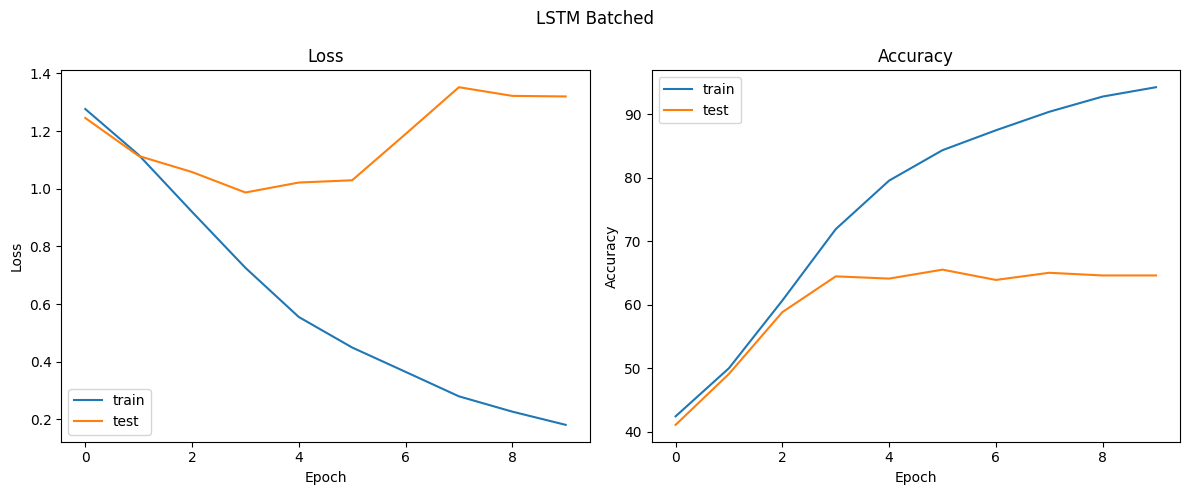

Best loss: 0.9870, Best accuracy: 64.48%
Training time: 11.48s


In [ ]:
lstm_batched = LSTMBatched(BL_EMBEDDING_DIM, BL_HIDDEN_DIM, BL_LAYER, BL_DROPOUT, num_classes, tokenizer)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(lstm_batched.parameters(), lr=BL_LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

lstm_batched_results = train_model(
    lstm_batched, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=BL_EPOCHS, device=device
)
lstm_batched_results["name"] = "LSTM Batched"
lstm_batched_results["best_test_df"] = test(lstm_batched_results["best_model_wts"], test_loader, criterion, device)[2]
plot_stats(lstm_batched_results)

print(f"Best loss: {lstm_batched_results['best_loss']:.4f}, Best accuracy: {lstm_batched_results['best_acc']:.2f}%")
print(f"Training time: {lstm_batched_results['train_time']:.2f}s")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

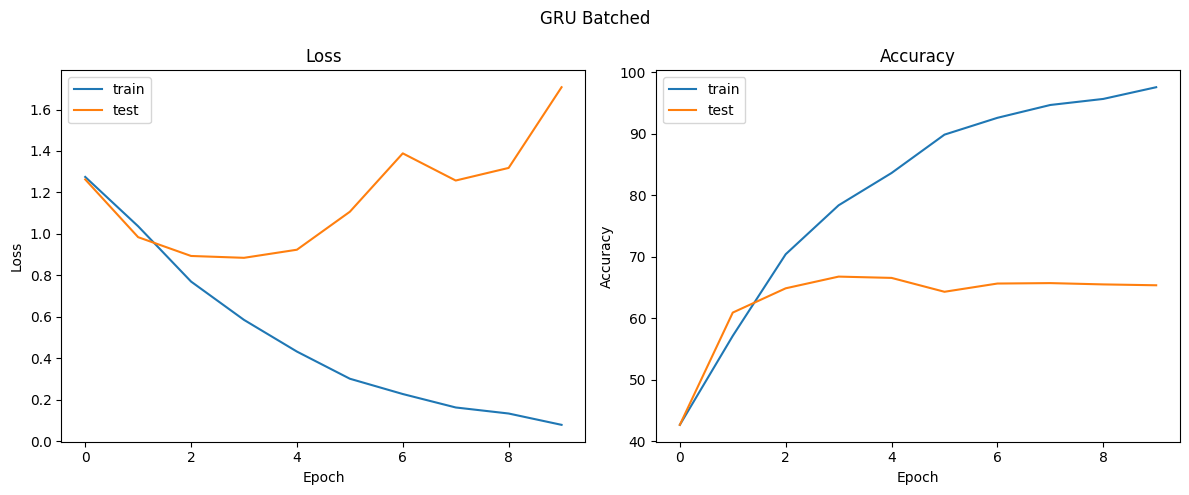

Best loss: 0.8843, Best accuracy: 66.81%
Training time: 9.72s


In [ ]:
gru_batched = GRUBatched(BL_EMBEDDING_DIM, BL_HIDDEN_DIM, BL_LAYER, BL_DROPOUT, num_classes, tokenizer)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru_batched.parameters(), lr=BL_LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

gru_batched_results = train_model(
    gru_batched, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=BL_EPOCHS, device=device
)
gru_batched_results["name"] = "GRU Batched"
gru_batched_results["best_test_df"] = test(gru_batched_results["best_model_wts"], test_loader, criterion, device)[2]
plot_stats(gru_batched_results)

print(f"Best loss: {gru_batched_results['best_loss']:.4f}, Best accuracy: {gru_batched_results['best_acc']:.2f}%")
print(f"Training time: {gru_batched_results['train_time']:.2f}s")

In [ ]:
def plot_confusion_matrix(df):
    confusion_matrix = pd.crosstab(df["true_label"], df["pred_label"], rownames=["True"], colnames=["Predicted"], normalize='index')
    plt.figure(figsize=(5, 5))
    plt.imshow(confusion_matrix, cmap="Blues")
    plt.xticks(range(len(mapping)), mapping.values(), rotation=45)
    plt.yticks(range(len(mapping)), mapping.values())
    plt.colorbar()
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.title("Confusion matrix")
    plt.show()

def plot_acc_per_class(df):
    acc_per_class = calculate_test_accuracy_per_class(df)
    plt.figure(figsize=(10, 5))
    plt.bar(acc_per_class.keys(), acc_per_class.values(), color="blue", alpha=0.5)
    plt.xticks(rotation=45)
    plt.title("Accuracy per class")
    plt.show()

In [ ]:
# lstm_batched_results["best_test_df"].head()
sampled = lstm_batched_results["best_test_df"].sample(5)
for i, row in sampled.iterrows():
    text = " ".join(row["text"])
    text = text.replace("<PAD>", "")
    print(f"Text: {text}")
    print(f"True: {row['true_label']}, Pred: {row['pred_label']}")
    print(f"Probs: {clean_probs(row['probs'])}")
    print()

Text: <UNK> anger lack job <UNK> <UNK> <UNK> <UNK> <UNK> situation       
True: anger, Pred: anger
Probs: anger (96%), joy (0%), optimism (0%), sadness (4%)

Text: fuck offend feel like             
True: anger, Pred: anger
Probs: anger (92%), joy (1%), optimism (1%), sadness (6%)

Text: <UNK> <UNK> begin <UNK> <UNK> <UNK>               
True: anger, Pred: sadness
Probs: anger (23%), joy (27%), optimism (19%), sadness (30%)

Text: go bed dry clean hair # <UNK>             
True: joy, Pred: sadness
Probs: anger (9%), joy (4%), optimism (1%), sadness (85%)

Text: moment people need <UNK> mind matter need stop # <UNK>         
True: anger, Pred: anger
Probs: anger (39%), joy (16%), optimism (13%), sadness (32%)



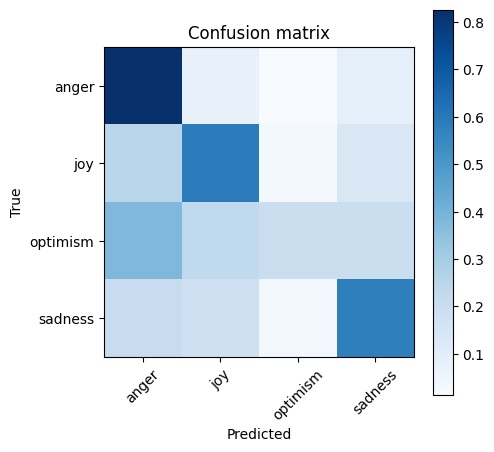

In [ ]:
plot_confusion_matrix(lstm_batched_results["best_test_df"])

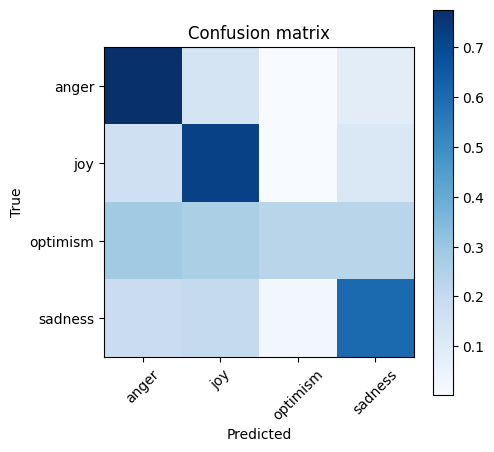

In [ ]:
plot_confusion_matrix(gru_batched_results["best_test_df"])

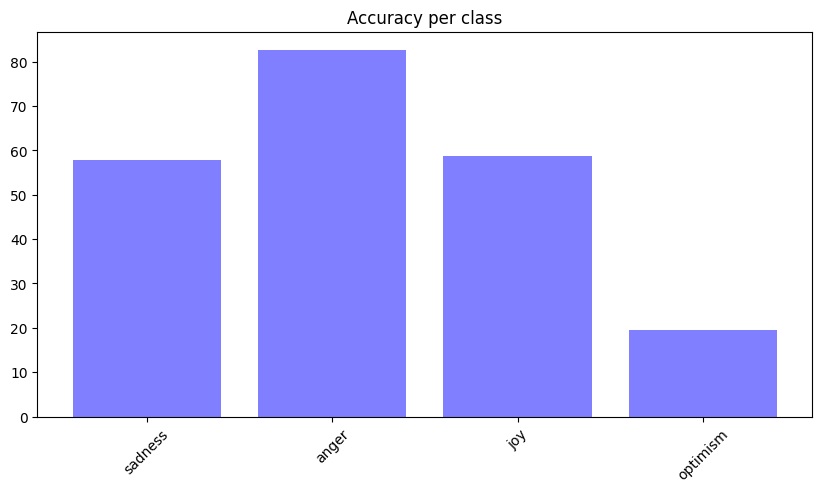

In [ ]:
plot_acc_per_class(lstm_batched_results["best_test_df"])

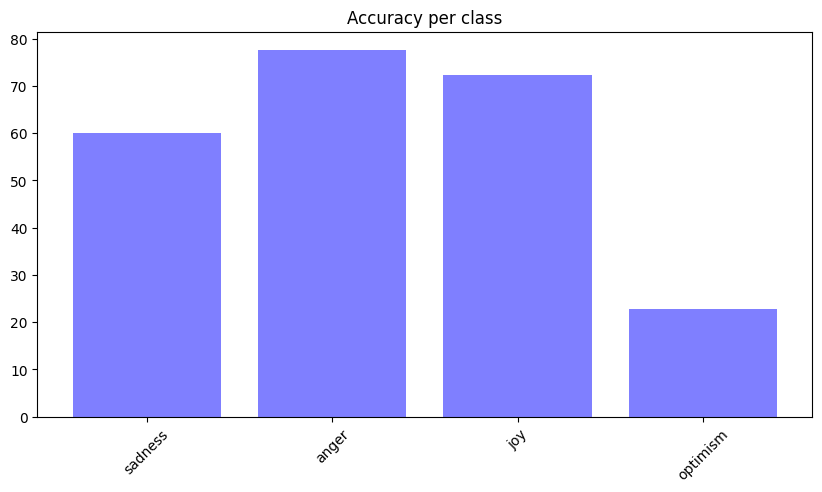

In [ ]:
plot_acc_per_class(gru_batched_results["best_test_df"])